In [19]:
# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

from pylab import rcParams
# from plotly import tools
# import plotly.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.figure_factory as ff

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# 1.load data

In [20]:
all_df = pd.read_csv("data/owid-covid-data.csv",  keep_default_na=False)
population_ = pd.read_csv('data/population_by_country_2020.csv')

In [21]:
population_.loc[population_['Country (or dependency)'] == 'United States', 'Country (or dependency)'] = "US"
population_.loc[population_['Country (or dependency)'] == 'South Korea', 'Country (or dependency)'] = "Korea, South"
population_.loc[population_['Country (or dependency)'] == 'Sao Tome & Principe', 'Country (or dependency)'] = "Sao Tome and Principe"
population_.loc[population_['Country (or dependency)'] == 'Taiwan', 'Country (or dependency)'] = "Taiwan*"

population_.loc[population_['Country (or dependency)'] == 'Myanmar', 'Country (or dependency)'] = "Burma"
population_.loc[population_['Country (or dependency)'] == 'Congo', 'Country (or dependency)'] = "Congo (Brazzaville)"
population_.loc[population_['Country (or dependency)'] == 'DR Congo', 'Country (or dependency)'] = "Congo (Kinshasa)"
population_.loc[population_['Country (or dependency)'] == "Côte d'Ivoire", 'Country (or dependency)'] = "Cote d'Ivoire"

population_.loc[population_['Country (or dependency)'] == 'Czech Republic (Czechia)', 'Country (or dependency)'] = "Czechia"
population_.loc[population_['Country (or dependency)'] == 'Saint Kitts & Nevis', 'Country (or dependency)'] = "Saint Kitts and Nevis"
population_.loc[population_['Country (or dependency)'] == 'St. Vincent & Grenadines', 'Country (or dependency)'] = "Saint Vincent and the Grenadines"


population_.rename({'Population (2020)': 'population', 'Country (or dependency)': 'country', 'Yearly Change': 'yearly_change', 
                 'Net Change': 'net_change', 'Density (P/Km²)': 'density', 'Land Area (Km²)': 'land_area', 
                 'Migrants (net)': 'migrants', 'Fert. Rate': 'rert_rate', 'Med. Age': 'med_age', 
                 'Urban Pop %': 'urban_pop', 'World Share': 'world_share'}, axis=1, inplace=True)
population_["yearly_change"] = population_["yearly_change"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")
population_["urban_pop"] = population_["urban_pop"].apply(lambda x: x.replace(" ", "").replace("N.A.","0").replace("%","")).astype("float")
population_["world_share"] = population_["world_share"].apply(lambda x: x.replace(" ", "").replace("%","")).astype("float")

population_["rert_rate"] = population_["rert_rate"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")
population_["med_age"] = population_["med_age"].apply(lambda x: x.replace("N.A.", "0.0")).astype("float")

population_.rert_rate.fillna(0, inplace=True)
population_.migrants.fillna(0, inplace=True)

population_["net_change"] = population_["net_change"].astype("float")
population_["density"] = population_["density"].astype("float")
population_["land_area"] = population_["land_area"].astype("float")
population_["population"] = population_["population"].astype("float")

population_["r_population"] = population_["population"]

population_["population"] = population_["population"] / max(population_["population"])
population_["yearly_change"] = population_["yearly_change"] / max(population_["yearly_change"])
population_["urban_pop"] = population_["urban_pop"] / max(population_["urban_pop"])
population_["world_share"] = population_["world_share"] / max(population_["world_share"])
population_["net_change"] = population_["net_change"] / max(population_["net_change"])
population_["density"] = population_["density"] / max(population_["density"])
population_["land_area"] = population_["land_area"] / max(population_["land_area"])
population_["rert_rate"] = population_["rert_rate"] / max(population_["rert_rate"])
population_["med_age"] = population_["med_age"] / max(population_["med_age"])
population_["migrants"] = population_["migrants"] / max(population_["migrants"])

In [22]:
def deal_country_data(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    df = pd.DataFrame()
    df["country"] = data_df["location"]
    df["date"] = data_df["date"]
    df["confirmed"] = data_df["new_cases"]
    df["fatalities"] = data_df["new_deaths"]
    # df["population"] = train_df["population"]
    df["population_density"] = data_df["population_density"]
    df["median_age"] = data_df["median_age"]
    df["aged_65_older"] = data_df["aged_65_older"]
    df["aged_70_older"] = data_df["aged_70_older"]
     
    country_df = df.merge(population_, how="left", on=['country']).drop_duplicates()
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    country_df["population_density"] = pd.to_numeric(country_df["population_density"])
    country_df["median_age"] = pd.to_numeric(country_df["median_age"])
    country_df["aged_65_older"] = pd.to_numeric(country_df["aged_65_older"])
    country_df["aged_70_older"] = pd.to_numeric(country_df["aged_70_older"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    return  country_df

def deal_global_df(population_, train_df, oname, nname):
    data_df = train_df[train_df["location"] == oname]
    data_df["location"] = nname
    
    country_df = pd.DataFrame()
    country_df["country"] = data_df["location"]
    country_df["date"] = data_df["date"]
    country_df["confirmed"] = data_df["new_cases"]
    country_df["fatalities"] = data_df["new_deaths"]
    
    country_df.confirmed.fillna(0, inplace=True)
    country_df.fatalities.fillna(0, inplace=True)
    country_df["confirmed"] = pd.to_numeric(country_df["confirmed"])
    country_df["fatalities"] = pd.to_numeric(country_df["fatalities"])
    
    country_df["confirmed"] = np.abs(country_df["confirmed"])
    country_df["fatalities"] = np.abs(country_df["fatalities"])
    
    list_cur = []
    list_cur.append({"country":nname,
                "population":population_["population"].mean(),
                "yearly_change":population_["yearly_change"].mean(),
                "net_change":population_["net_change"].mean(),
                "density":population_["density"].mean(),
                "land_area":population_["land_area"].mean(),
                "migrants":population_["migrants"].mean(),
                "rert_rate":population_["rert_rate"].mean(),
                "med_age":population_["med_age"].mean(),
                "urban_pop":population_["urban_pop"].mean(),
                "world_share":population_["world_share"].mean()})
    df = pd.DataFrame(list_cur)
    
    data_df = country_df.merge(df, how="left", on=['country']).drop_duplicates()
    
    
    return data_df

def log2_(df):
    df = df[df["confirmed"] >= 3]
    df = df[df["fatalities"] >= 3]
    df["confirmed"] = np.log(np.log(df["confirmed"]))
    df["fatalities"] = np.log(np.log(df["fatalities"]))
    idex = list(range(0, df.shape[0]))
    df["day"] = idex
    return df

def plot_data(t):

    plt.plot(range(0, t.shape[0]), t["confirmed"])
    plt.plot(range(0, t.shape[0]), t["fatalities"])
    plt.title('Confirmed & Fatalities Data')
    plt.ylabel('confirmed & Fatalities')
    plt.xlabel('Epoch')
    plt.show()

def saveCsv(df, name):
    df = df.fillna(0)
    df.to_csv("/home/soul/NewWorkSpace/Informer2020CP/data/ETT/" + name + ".csv")
    
def addCsv(df): #累加
    temp_df = df
    confirmed_ = temp_df.confirmed.fillna(0).astype(np.float32)
    fatalities_ = temp_df.fatalities.fillna(0).astype(np.float32)
    confirmed_ = np.array(confirmed_).reshape(-1, 1)
    fatalities_ = np.array(fatalities_).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df

def plot_data(t):
    plt.plot(range(0, t.shape[0]), t["confirmed"])
    plt.plot(range(0, t.shape[0]), t["fatalities"])
    plt.title('Confirmed & Fatalities Data')
    plt.ylabel('confirmed & Fatalities')
    plt.xlabel('Epoch')
    plt.show()

from sklearn.preprocessing import StandardScaler
class StandData:
    def __init__(self):
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
    
    def standData_(self, df):

        confirmed_  = df.confirmed.fillna(0)
        fatalities_ = df.fatalities.fillna(0)

        confirmed_ = np.array(confirmed_)
        fatalities_ = np.array(fatalities_)

        self.scaler1.fit(confirmed_.reshape(-1, 1))
        confirmed_ = self.scaler1.transform(confirmed_.reshape(-1, 1)).reshape(-1)

        self.scaler2.fit(fatalities_.reshape(-1, 1))
        fatalities_ = self.scaler2.transform(fatalities_.reshape(-1, 1)).reshape(-1)
        
        temp_df = pd.DataFrame()
        temp_df["confirmed"] = confirmed_
        temp_df["fatalities"] = fatalities_
        idex = list(range(0, df.shape[0]))
        temp_df["day"] = idex
        return temp_df
    
    def transformDataConfirmed_(self, df):
        return self.scaler1.inverse_transform(df)
    
    def transformDataFatalities_(self, df):
        return self.scaler2.inverse_transform(df)
    
def error_mse(ty, py):
    mse = mean_squared_error(ty, py)
    return mse

def error_rmsle(ty, py):
    rmsle = np.sqrt(mean_squared_log_error(ty, py))
    return rmsle

def error_mae(ty, py):
    mae = mean_absolute_error(ty, py)
    return mae

def error_mape(ty, py):
    mape = np.mean(np.abs((py - ty) / ty)) 
    return mape

def error_rmse(ty, py):
    mse = mean_squared_error(ty, py)    
    rmse = np.sqrt(mse)
    return rmse

In [23]:
global_df = deal_global_df(population_, all_df, "World", "global")
us_df = deal_country_data(population_, all_df, "United States", "US")
italy_df  = deal_country_data(population_, all_df, "Italy", "Italy")    ####
france_df = deal_country_data(population_, all_df, "France", "France")  ####
japan_df  = deal_country_data(population_, all_df, "Japan", "Japan")    ####


china_df = deal_country_data(population_, all_df, "China", "China")
spain_df = deal_country_data(population_, all_df, "Spain", "Spain")
france_df = deal_country_data(population_, all_df, "France", "France")
uk_df = deal_country_data(population_, all_df, "United Kingdom", "United Kingdom")
germany_df = deal_country_data(population_, all_df, "Germany", "Germany")


In [24]:
global_df

,country,date,confirmed,fatalities,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share
0,global,2020-01-22,0.0,0.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
1,global,2020-01-23,98.0,1.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
2,global,2020-01-24,286.0,8.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
3,global,2020-01-25,492.0,16.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
4,global,2020-01-26,685.0,14.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,global,2021-04-21,889975.0,14100.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
456,global,2021-04-22,899755.0,13729.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
457,global,2021-04-23,897839.0,14277.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
458,global,2021-04-24,821237.0,13316.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034


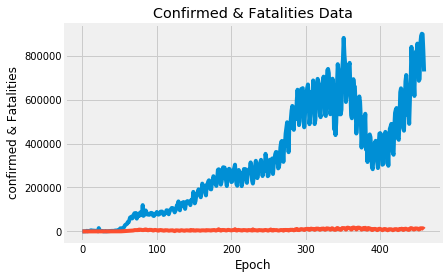

In [25]:
plot_data(global_df)

In [13]:
def baseling_ARMA(df, feature = "fatalities"):
    standData = StandData()
    df = standData.standData_(df)
    model = ARMA(df['fatalities'].iloc[:-30], order=(1, 0)) #(1, 0)  (0, 1)  (0, 2) (0, 3) (3, 3)
    result = model.fit()
#     print(result.summary())
#     print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))
    rcParams['figure.figsize'] = 10, 8
    
    plt.plot(standData.transformDataFatalities_(df['fatalities'].iloc[:]),color="red")       
    plt.plot(standData.transformDataFatalities_(result.predict(start=459-30 + 1,end=459)),color="blue")    
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.show()
    plt.close()
    
    
    mse   = error_mse(df['fatalities'].iloc[-30:], result.predict(start=459-30 + 1,end=459))
#     rmsle = error_rmsle(df['fatalities'].iloc[-30:], result.predict(start=459 - 30 + 1,end=459))
    mae   = error_mae(df['fatalities'].iloc[-30:], result.predict(start=459-30 + 1,end=459))
    mape  = error_mape(df['fatalities'].iloc[-30:], result.predict(start=459-30 + 1,end=459))
    rmse  = error_rmse(df['fatalities'].iloc[-30:], result.predict(start=459-30 + 1,end=459))
    print("mse: ", mse)
#     print("rmsle: ", rmsle)
    print("mae: ", mae)
    print("mape: ", mape)
    print("rmse: ", rmse)

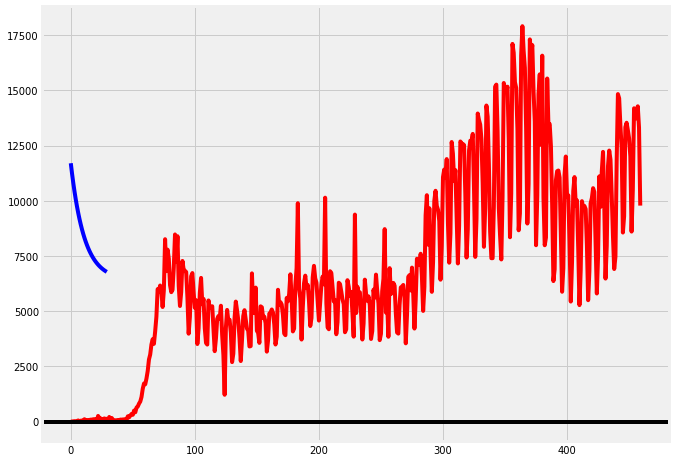

mse:  1.2122516254359803
mae:  0.9590202255872919
mape:  1.800885847677919
rmse:  1.1010229904211721


In [14]:
baseling_ARMA(global_df.copy(), 'fatalities')

In [44]:
global_df

,country,date,confirmed,fatalities,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share
0,global,2020-01-22,0.0,0.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
1,global,2020-01-23,98.0,1.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
2,global,2020-01-24,384.0,9.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
3,global,2020-01-25,876.0,25.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
4,global,2020-01-26,1561.0,39.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,global,2021-04-21,143019072.0,3058128.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
456,global,2021-04-22,143918832.0,3071857.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
457,global,2021-04-23,144816672.0,3086134.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
458,global,2021-04-24,145637904.0,3099450.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034


# ARAM

In [271]:
global_df['confirmed'].iloc[:-30].shape

(404,)

In [272]:
model = ARMA(global_df['confirmed'].iloc[:-30], order=(1,0)) #(1, 0)  (0, 1)  (0, 2) (0, 3) (3, 3)
result = model.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                  404
Model:                     ARMA(1, 0)   Log Likelihood                1327.766
Method:                       css-mle   S.D. of innovations              0.009
Date:                Tue, 20 Apr 2021   AIC                          -2649.531
Time:                        10:54:09   BIC                          -2637.527
Sample:                             0   HQIC                         -2644.779
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0710        nan        nan        nan         nan         nan
ar.L1.confirmed     1.0000        nan        nan        nan         nan         nan
                                

In [274]:
np.array(result.predict(start=404,end=433)).shape

(30,)

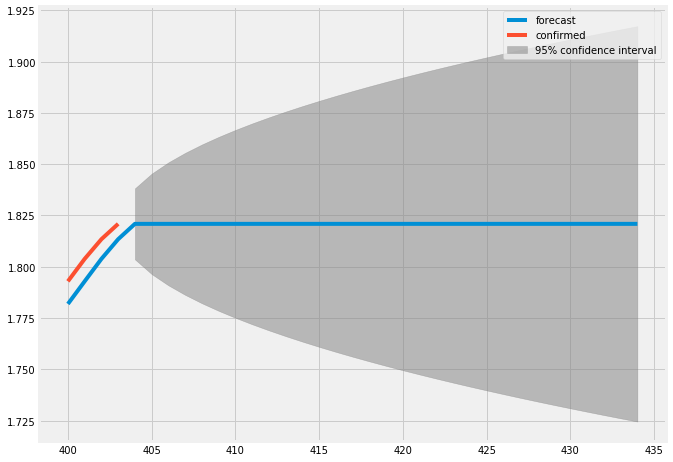

In [279]:
# Predicting simulated AR(1) model 
rcParams['figure.figsize'] = 10, 8
result.plot_predict(400, 434)
plt.show()

In [74]:
rmse = math.sqrt(mean_squared_error(global_df['confirmed'].iloc[400:434], result.predict(start=400,end=433)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 103812.19372507061.


In [ ]:
The root mean squared error is 128161.37744454228.

# MA

                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observations:                  398
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4832.027
Method:                       css-mle   S.D. of innovations          45331.079
Date:                Thu, 01 Apr 2021   AIC                           9672.054
Time:                        16:06:38   BIC                           9688.000
Sample:                             1   HQIC                          9678.370
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1117.2211   2129.493      0.525      0.600   -3056.508    5290.950
ar.L1.D.confirmed     0.1034      0.049      2.093      0.036       0.007       0.200
ar.L2.D.confirmed    -0.

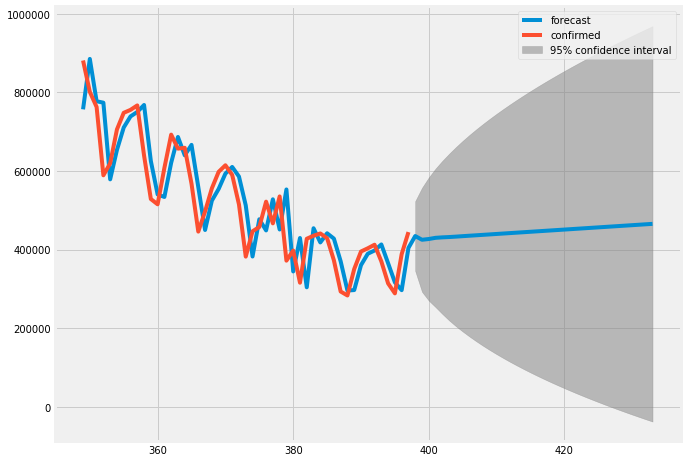

In [140]:
# Predicting the microsoft stocks volume
rcParams['figure.figsize'] = 10, 8
model = ARIMA(global_df['confirmed'].iloc[1:-34], order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(350, 434)
plt.show()

In [141]:
global_df['confirmed'].iloc[400:434].shape

(34,)

In [142]:
result.predict(start=399,end=433).shape

(35,)

In [143]:
rmse = math.sqrt(mean_squared_error(global_df['confirmed'].iloc[400:434], result.predict(start=399,end=433)[1:]))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 467955.591972731.


In [144]:
global_df.head()

,country,date,confirmed,fatalities,population,yearly_change,net_change,density,land_area,migrants,rert_rate,med_age,urban_pop,world_share
0,global,2020-01-22,0.0,0.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
1,global,2020-01-23,98.0,1.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
2,global,2020-01-24,286.0,8.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
3,global,2020-01-25,492.0,16.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034
4,global,2020-01-26,685.0,14.0,0.023013,0.287644,0.025473,0.018065,0.033803,0.000006,0.329058,0.54539,0.559574,0.023034


                                Statespace Model Results                               
Dep. Variable:     ['confirmed', 'fatalities']   No. Observations:                  400
Model:                              VARMA(2,1)   Log Likelihood               -8188.306
                                   + intercept   AIC                          16410.612
Date:                         Thu, 01 Apr 2021   BIC                          16478.466
Time:                                 16:25:56   HQIC                         16437.483
Sample:                                      0                                         
                                         - 400                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             4.61, 1.69   Jarque-Bera (JB):       146.61, 277.47
Prob(Q):                        0.03, 0.19   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):        23.09, 2.

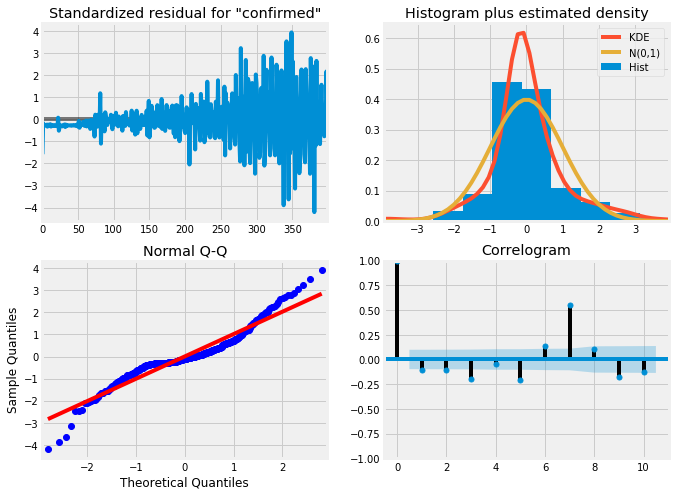

In [156]:
train_sample = pd.concat([global_df['confirmed'],global_df['fatalities']],axis=1)
model = sm.tsa.VARMAX(train_sample.iloc[:-34],order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
result.plot_diagnostics()

# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[400:434].values, result.predict(start=400, end=433)))
print("The root mean squared error is {}.".format(rmse))

## Logistic Regression

In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

def dealDataConfirmed(country_df):
    df = pd.DataFrame()
    df['confirmed'] = country_df.iloc[:].confirmed.fillna(0)
    df['day_count'] = list(range(1,len(df)+1))

    ydata = [i for i in df.confirmed]
    xdata = df.day_count
    ydata = np.array(ydata, dtype=float).reshape([-1, 1])
    xdata = np.array(xdata, dtype=float).reshape([-1, 1])

    tamp = -30
    x_train = xdata[:tamp]
    x_test = xdata[tamp:]
    y_train = ydata[:tamp]
    y_test = ydata[tamp:]
    
    return xdata, ydata, x_train, y_train, x_test, y_test

def dealDataFatalities(country_df):
    df = pd.DataFrame()
    df['fatalities'] = country_df.iloc[:].fatalities.fillna(0)
    df['day_count'] = list(range(1,len(df)+1))

    ydata = [i for i in df.fatalities]
    xdata = df.day_count
    ydata = np.array(ydata, dtype=float).reshape([-1, 1])
    xdata = np.array(xdata, dtype=float).reshape([-1, 1])

    tamp = -30
    x_train = xdata[:tamp]
    x_test = xdata[tamp:]
    y_train = ydata[:tamp]
    y_test = ydata[tamp:]
    
    return xdata, ydata, x_train, y_train, x_test, y_test


# 回归部分
def try_different_method(model, ModelName, dealDataMethod, data):
    standData = StandData()
    data = standData.standData_(data)
    xdata, ydata, x_train, y_train, x_test, y_test = dealDataMethod(data)
    model.fit(x_train, y_train)
    score = model.score(xdata, ydata)
    result = model.predict(xdata)
    plt.figure()
    plt.plot(np.arange(len(result)), ydata, "go-", label="Measured")
    plt.plot(np.arange(len(result)), result, "ro-", label="Predicted")
    plt.title(f"method:{ModelName}---score:{score}")
    plt.legend(loc="best")
    plt.show()
    
    
    mse   = error_mse(y_test, model.predict(x_test))
#     rmsle = error_rmsle(y_test, model.predict(x_test))
    mae   = error_mae(y_test, model.predict(x_test))
    mape  = error_mape(y_test, model.predict(x_test))
    rmse  = error_rmse(y_test, model.predict(x_test))
    print("mse: ", mse)
#     print("rmsle: ", rmsle)
    print("mae: ", mae)
    print("mape: ", mape)
    print("rmse: ", rmse)
    


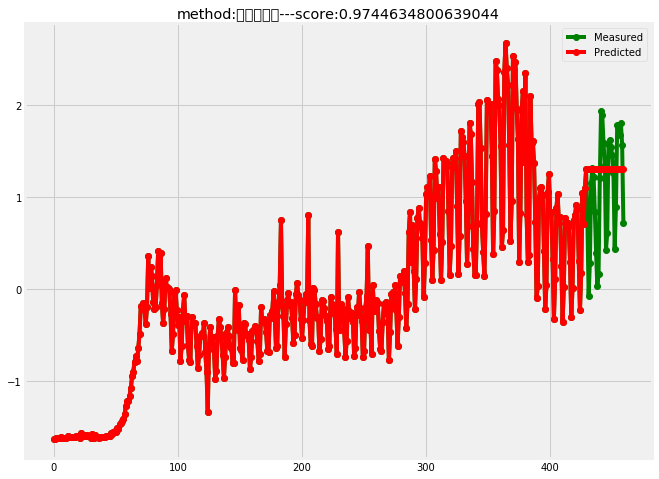

mse:  0.39155997235346546
mae:  0.5055188255247659
mape:  2.638195132894409
rmse:  0.6257475308408859


In [27]:
from sklearn import tree
model_decision_tree_regression = tree.DecisionTreeRegressor()
try_different_method(model_decision_tree_regression, "决策树回归", dealDataFatalities, global_df.copy())

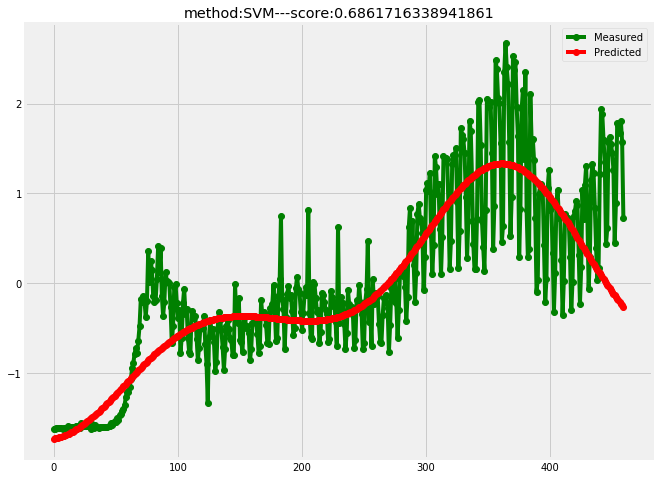

mse:  1.6646136628164763
mae:  1.1210149605635968
mape:  1.1433735577083324
rmse:  1.2901990787535373


In [28]:
from sklearn import svm
model_svm = svm.SVR()
try_different_method(model_svm, "SVM", dealDataFatalities, global_df)

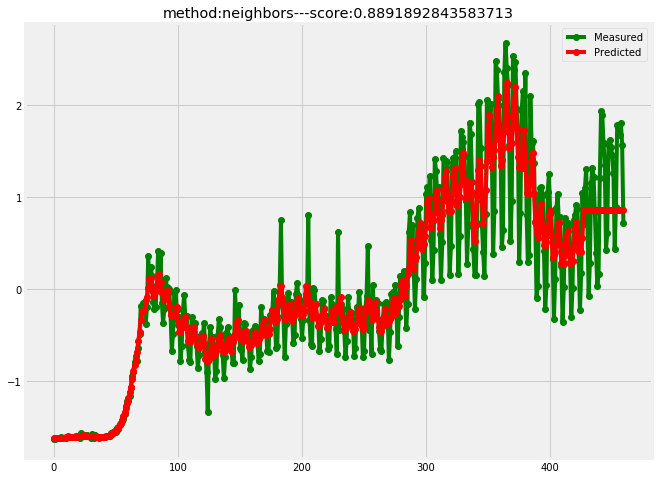

mse:  0.40951779850984626
mae:  0.5700835709074336
mape:  1.8260463702798275
rmse:  0.6399357768634648


In [29]:
from sklearn import neighbors
model_k_neighbor = neighbors.KNeighborsRegressor()
try_different_method(model_k_neighbor, "neighbors", dealDataFatalities, global_df)

In [26]:
## 2019.11.1
#     time_step = 3       lstm-cell个数
#     n_inputs = 1        输入大小， 也就是look-back
#     n_outputs = 1       输出大小， 全连接输出
#     iter_epoch = 100    训练次数
#     batch_size = 10     每次训练的大小
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

session = tf.Session(config=config)

def addCsv(df): #累加
    temp_df = df
    confirmed_ = np.array(temp_df['confirmed'].astype(np.float32)).reshape(-1, 1)
    fatalities_ = np.array(temp_df['fatalities'].astype(np.float32)).reshape(-1, 1)
    for i in range(confirmed_.shape[0] - 1):
        confirmed_[i+1] += confirmed_[i]
    for i in range(fatalities_.shape[0] - 1):
        fatalities_[i+1] += fatalities_[i]    
    temp_df['confirmed'] = confirmed_
    temp_df['fatalities'] = fatalities_
    return temp_df


## 将数据转换为x, y
## 这个函数将创造一个数据， x为时间t时刻的数据， y为时间t+1时刻的数据
## look_back  指代 我们需要过去多少个时间点的数据作为输入 预测下一个点的数据
def create_dataset_train(data, look_back=1, input_data = None):
    dataX1, dataY1 = create_dataset_front(data, look_back)
    dataX2, dataY2 = create_dataset_front(data, look_back)
    dataX = np.vstack([dataX1, dataX2])
    dataY = np.vstack([dataY1, dataY2])
    if input_data is not None:
        dataX3, dataY3 = create_train_sequences(input_data, look_back)
        dataX = np.vstack([dataX, dataX3])
        dataY = np.vstack([dataY, dataY3])
    return dataX, dataY

def create_train_sequences(input_data, look_back):
    dataX, dataY = [], []
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1])
    for i in range(input_data.shape[0]):
        dataX.append(input_data[i][0:look_back])
        dataY.append(input_data[i][look_back])
    return np.array(dataX), np.array(dataY).reshape([-1, 1])

def create_dataset_front(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data[i+look_back])
    return np.array(dataX).reshape([-1, look_back]), np.array(dataY).reshape([-1, 1])

def create_dataset_back(data, look_back=1):
    dataX, dataY = [], []
    for i in range(look_back, len(data)):
        dataX.append(data[(i - look_back) : i])
        dataY.append(data[i])
    return np.array(dataX).reshape([-1, look_back]), np.array(dataY).reshape([-1, 1])

from sklearn.preprocessing import StandardScaler
class DealData:
    def __init__(self, extraDataPos = None):
        self.scaler = StandardScaler()
        self.amplitude = pd.read_csv('/home/soul/NewWorkSpace/Covid_2021_4_18/data/global.csv')
        self.amplitude = np.array(self.amplitude['fatalities'].astype(np.float32))
        
        self.scaler.fit(self.amplitude.reshape(-1, 1))
        self.amplitude = self.scaler.transform(self.amplitude.reshape(-1, 1)).reshape(-1)
        
        if extraDataPos is not None:
            self.trainData = np.load(extraDataPos)
        else:
            self.trainData = None

        
    def trainTestData(self, look_back = 50):
        train_sampels = -30 
        test_samples = -80
        train_data = self.amplitude[:train_sampels]
        test_data = self.amplitude[test_samples:]
        
        trainX, trainY = create_dataset_train(train_data, look_back, self.trainData)
        testX, testY   = create_dataset_train(test_data, look_back)
        
        return trainX, trainY, testX, testY
    
    def transeformData(self, data):
        return self.scaler.inverse_transform(data)
    

def mean_square_error(pred, y):
    return np.power(np.sum(np.power(pred - y, 2)) / pred.shape[0], 0.5)


def lstm_net(X, y, batch_size, units=100, learning_rate=0.002):
    lstm_cells = []
    for i in range(2):
        lstm_cells.append(tf.contrib.rnn.BasicLSTMCell(units, forget_bias=1.0, state_is_tuple=True))

    multi_lstm = tf.contrib.rnn.MultiRNNCell(lstm_cells, state_is_tuple=True)

    init_state = multi_lstm.zero_state(batch_size, dtype=tf.float32)

    # batch_size, units
    outputs, final_state = tf.nn.dynamic_rnn(multi_lstm, X, initial_state=init_state, time_major=False)

    outputs = tf.reshape(outputs, [-1, units * X.shape[1]])
    result = tf.layers.dense(outputs, units=1, activation=None)

    loss = tf.reduce_mean(tf.square(y - result))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


    return result, loss, train_op

def train(lookback = 50, extraDataPos = None):
    tf.reset_default_graph()
    
    dealData = DealData(extraDataPos)
    trainX, trainY, testX, testY = dealData.trainTestData(lookback)
    print(trainX.shape)
    print(trainY.shape)
    ## reshape input to [samples, time step, features]
    trainX = np.reshape(trainX, newshape=[trainX.shape[0], trainX.shape[1], 1])
    testX = np.reshape(testX, newshape=[testX.shape[0], testX.shape[1], 1])


    time_step = lookback
    n_inputs = 1
    n_outputs = 1
    iter_epoch = 100
    batch_size = 60


    x = tf.placeholder(tf.float32, shape=[None, time_step, n_inputs])
    y = tf.placeholder(tf.float32, shape=[None, n_outputs])
    result, loss, train_op = lstm_net(x, y, batch_size)


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        re_loss = []
        for i in range(iter_epoch):
            temp = 0
#             ls, _ = sess.run([loss, train_op], feed_dict = {x : trainX, y : trainY})
            for j in range(int(trainX.shape[0] / batch_size)):
                tx = trainX[(j * batch_size):((j + 1) * batch_size), :, :]
                ty = trainY[(j * batch_size):((j + 1) * batch_size), :]
                ls, _ = sess.run([loss, train_op], feed_dict={x: tx, y: ty})
                temp += ls
            print(i, temp / trainX.shape[0])
            re_loss.append(temp / trainX.shape[0])


        plt.plot(range(iter_epoch), re_loss, c='red')
        plt.show()


#         re_train = []
#         for j in range(int(trainX.shape[0] / batch_size)):
#             tx = trainX[(j * batch_size):((j + 1) * batch_size), :, :]
#             ty = trainY[(j * batch_size):((j + 1) * batch_size), :]
#             pred = sess.run([result], feed_dict={x: tx, y: ty})
#             re_train.append(pred)


        re_test = []
        re_test = sess.run([result], feed_dict={x: testX, y: testY})
#         for j in range(int(testX.shape[0])):
#             tx = testX[(j * batch_size):((j + 1) * batch_size), :, :]
#             ty = testY[(j * batch_size):((j + 1) * batch_size), :]
#             pred = sess.run([result], feed_dict={x: tx, y: ty})
#             re_test.append(pred)


#         re_train = np.array(re_train).reshape([-1, 1])
        re_test = np.array(re_test).reshape([-1, 1])


#         re_train = scaler.inverse_transform(re_train)
#         re_test = scaler.inverse_transform(re_test)
#         data = scaler.inverse_transform(data)


#         ## plot  训练集预测
#         plt.plot(range(re_train.shape[0]), re_train, label='Train Predict')
#         ## plot 测试集预测
#         plt.plot(range(tst, tst + re_test.shape[0]), re_test, label='Test Predict')
#         ## plot 实际数据
#         plt.plot(range(data.shape[0]), data, label='Data')
#         plt.legend()
#         plt.show()


#         print('Train Accuary  {:.3f}'.format(np.sqrt(mean_square_error(re_train, trainY[0:re_train.shape[0]]))))
        
        mse   = error_mse(testY, re_test)
#         rmsle = error_rmsle(testY, re_test)
        mae   = error_mae(testY, re_test)
        mape  = error_mape(testY, re_test)
        rmse  = error_rmse(testY, re_test)
        print("mse: ", mse)
#         print("rmsle: ", rmsle)
        print("mae: ", mae)
        print("mape: ", mape)
        print("rmse: ", rmse)


In [27]:
dealData = DealData()
trainX, trainY, testX, testY = dealData.trainTestData()
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(760, 50) (760, 1)
(60, 50) (60, 1)


(760, 50)
(760, 1)
0 0.007924707341743144
1 0.007352731876859539
2 0.008319354723942907
3 0.005232214672785057
4 0.005193123368448333
5 0.004052442969068101
6 0.003258629711835008
7 0.0029582092391425055
8 0.002713831558235382
9 0.0025151673557334826
10 0.0023902880812161848
11 0.002498090855385128
12 0.002266982398731144
13 0.001793781300320437
14 0.0015877303814417437
15 0.0014645100914333995
16 0.0015328632275524892
17 0.0015522760584166175
18 0.0014903496509711994
19 0.0013195061811098927
20 0.0012367294978742538
21 0.001201766822487116
22 0.0012127107622003869
23 0.0015634476158179736
24 0.0023042285986440746
25 0.0015304541362351493
26 0.0014931097087499342
27 0.0014034472626486892
28 0.001269360619450086
29 0.0011843491125067599
30 0.0011151501467745555
31 0.0011014066415985949
32 0.001088556610537987
33 0.0010756236844156918
34 0.0010604922169525372
35 0.001051977296408854
36 0.0010475393923881807
37 0.0010429413768609887
38 0.0010365777894070275
39 0.0010278439051226566
40 0.0

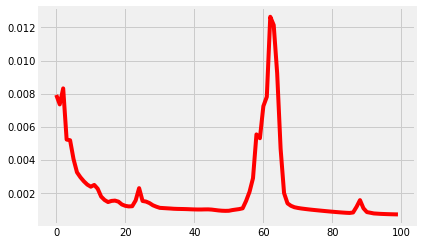

mse:  0.11547737
mae:  0.2628271
mape:  0.30728868
rmse:  0.3398196


In [28]:
# 不使用Gan数据
if __name__ == '__main__':
    train()

(1760, 50)
(1760, 1)
0 0.016214225411584432
1 0.014278120920062065
2 0.011903001202947714
3 0.010671229649927805
4 0.010875976062379777
5 0.00886560267853466
6 0.008024143988520584
7 0.006876052308573641
8 0.00545467157128521
9 0.0038797591707076537
10 0.0032913498707454313
11 0.00301732022780925
12 0.0024224279511889275
13 0.0021364005875181068
14 0.001940291731576012
15 0.0017359883535060692
16 0.001803261244838888
17 0.0016520100931467657
18 0.001531252979343249
19 0.0015018887796693226
20 0.0014564957416785711
21 0.001423337694723159
22 0.0014740511214106598
23 0.0017319026731208644
24 0.0015652610729871826
25 0.001646045053547079
26 0.0014133400474251672
27 0.0014107680731368336
28 0.0018092950943603434
29 0.0012907810329290275
30 0.001295503309335221
31 0.0012096745586446063
32 0.0012387712909416719
33 0.0011825501029802995
34 0.0010951666849326682
35 0.0010789263041012665
36 0.0010189976627853784
37 0.0009923806287009608
38 0.0009787386643107642
39 0.0009576853989115493
40 0.000

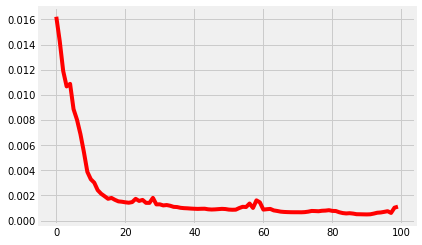

mse:  0.21313657
mae:  0.36786804
mape:  0.5847895
rmse:  0.46166715


In [29]:
# 使用Gan数据
if __name__ == '__main__':
    train(50, "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_noise_1000_everyday.npy")

(1760, 50)
(1760, 1)
0 0.012402163234285333
1 0.010821369679814036
2 0.01284757119349458
3 0.007835985322228886
4 0.006420286008241502
5 0.005810913697562434
6 0.006458519134585831
7 0.005094227884811434
8 0.004080690176818859
9 0.0036451516948132353
10 0.003381300033916804
11 0.003066104593348097
12 0.003092424586330625
13 0.0028037386523051696
14 0.002866788062436337
15 0.003486071624369784
16 0.004151390226219188
17 0.0031480634966018525
18 0.0027339666679670866
19 0.0029575305313549257
20 0.002702859259972518
21 0.002388927296058021
22 0.002754537227817557
23 0.003029167025604031
24 0.0027459823992103337
25 0.0026963296240534295
26 0.0024614799979396844
27 0.0023963446855883707
28 0.0027107903035357593
29 0.002446527283808047
30 0.0022961615457792175
31 0.002644379485652528
32 0.002195310838181864
33 0.0023933773542839016
34 0.002268782399848781
35 0.0023707660613581536
36 0.002241285831074823
37 0.002248043744740161
38 0.002270149467089637
39 0.00221966428428211
40 0.0022464509534

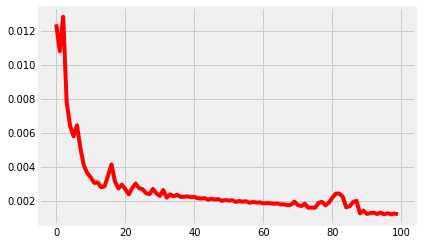

mse:  0.098268494
mae:  0.24566212
mape:  0.4598385
rmse:  0.31347805


In [30]:
# 使用随机噪声的GAN数据  
if __name__ == '__main__':
    train(50, "/home/soul/NewWorkSpace/Covid_2021_4_18/ganDataNew/stand_global_del30_fatality_SJ_noise_1000_everyday.npy")
